In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import seaborn as sns
from scipy import stats
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
sns.set()

In [2]:
#Build NA covid data for all airport comparisons
# Build total + new NA cases
NaData = pd.read_csv("Archived-Data/casesNA.csv", compression = 'gzip')
NaData["Date"] = pd.to_datetime(NaData["Date"])
NaSums = NaData.groupby(NaData['Date']).sum().reset_index()
naCases = NaSums[['Date','Confirmed']]
temp = naCases.shift(1)
naCases['New'] = naCases['Confirmed'] - temp['Confirmed']
naCases.loc[0,"New"] = 0
new_cases_smooth = lowess(naCases['New'], naCases["Date"], frac =0.05)
confirm_smooth = lowess(naCases['Confirmed'], naCases["Date"], frac =0.05)
naCases['New_smooth'] = new_cases_smooth[:,1]
naCases['Confirm_smooth'] = confirm_smooth[:,1]

<ipython-input-2-63b4a93f1e32>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  naCases['New'] = naCases['Confirmed'] - temp['Confirmed']
/home/dogfish/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-2-63b4a93f1e32>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

In [3]:
yvr = pd.read_csv('yvr4analyze_both.csv')
yvrCases = pd.read_csv('Covid-Data/yvr-modified.csv')
yvr["Date"] = pd.to_datetime(yvr["Date"])
yvrCases["Date"] = pd.to_datetime(yvrCases["Date"])

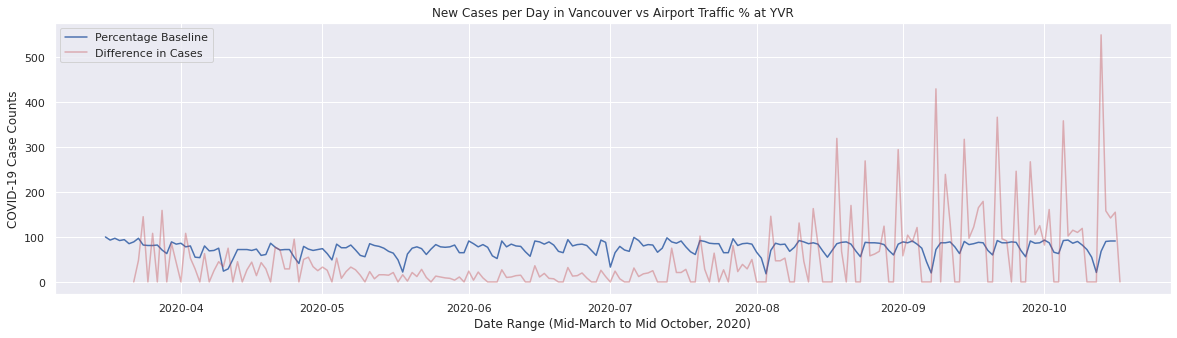

In [4]:
plt.figure(figsize = (20,5))
plt.plot(yvr["Date"], yvr['PercentOfBaseline'], 'b-', label = 'Percentage Baseline')
plt.plot(yvrCases["Date"], yvrCases['Difference'], 'r-', label = 'Difference in Cases', alpha = 0.4)
#plt.plot(yvrCases["Date"], yvrCases['Confirmed'], 'm-', label = 'Difference in Cases', alpha = 0.4)
plt.xlabel("Date Range (Mid-March to Mid October, 2020)")
plt.ylabel("COVID-19 Case Counts")
plt.title("New Cases per Day in Vancouver vs Airport Traffic % at YVR")
plt.legend()
plt.savefig('graphs/png/YVR/YVR.png', bbox_inches='tight', dpi = 150)

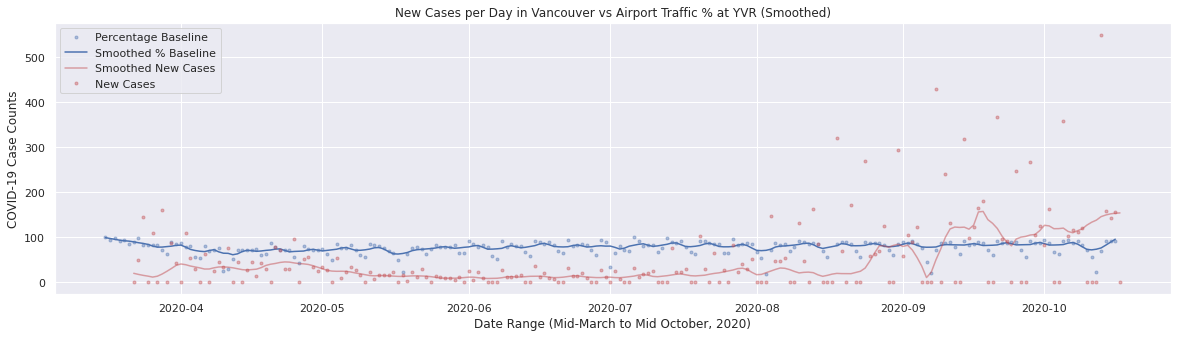

In [5]:
# We see that new cases per day is 0 sometimes, which isn't actually true, just that maybe
# the cases found for a couple of days aren't logged that day, but instead logged on another day, so we should
# smooth the new cases over a couple of days
# We also want to smooth out the weekly cycles in the data to see the long-run correlations
new_cases_smooth = lowess(yvrCases['Difference'], yvrCases["timestamp"], frac =0.05)#,is_sorted = True, return_sorted=False)
baseline_smooth = lowess(yvr['PercentOfBaseline'], yvr["Date"], frac =0.04) #to reduce weekly cycle effect 7/214 = 0.327
yvrCases['Diff_smooth'] = new_cases_smooth[:,1]
yvr['Baseline_smooth'] = baseline_smooth[:,1]
# This is to make sure both yvr and yvrCases start and end on the same dates
if (yvr.count().loc['Date'] != yvrCases.count().loc['Date']):
    joined = yvrCases[["Date","Difference","Confirmed","Diff_smooth"]].join(yvr[["Date","PercentOfBaseline","Baseline_smooth"]].set_index('Date'), on='Date')
    joined = joined.dropna()
    X = joined["Diff_smooth"]
    y = joined["Baseline_smooth"]
else:
    X = yvrCases["Diff_smooth"]
    y = yvr["Baseline_smooth"]

#print(joined.count())
#can use X,y or original, doesn't really matter
plt.figure(figsize = (20,5))
plt.plot(yvr["Date"], yvr['PercentOfBaseline'], 'b.', label = 'Percentage Baseline', alpha=0.4)
plt.plot(yvr["Date"], yvr['Baseline_smooth'],'b-',label = 'Smoothed % Baseline')
plt.plot(yvrCases["Date"], yvrCases["Diff_smooth"], 'r-', label = 'Smoothed New Cases', alpha = 0.5)
plt.plot(yvrCases["Date"], yvrCases['Difference'], 'r.', label = 'New Cases', alpha = 0.4)
plt.xlabel("Date Range (Mid-March to Mid October, 2020)")
plt.ylabel("COVID-19 Case Counts")
plt.title("New Cases per Day in Vancouver vs Airport Traffic % at YVR (Smoothed)")
plt.legend()
plt.savefig('graphs/png/YVR/YVRFiltered.png', bbox_inches='tight', dpi = 150)

0.3320289080751595


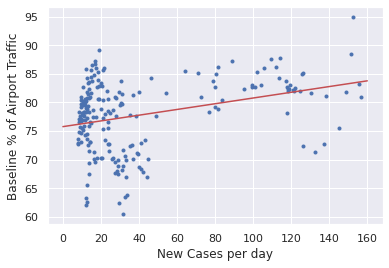

In [6]:
# Is there statistical correlation between the two values- Baseline, and New Cases?
# We use smoothed versions of data because don't want to analyze the weekly noise (tho holidays still exist)
# y = Diff
plt.plot(X,y, 'b.')
plt.xlabel('New Cases per day')
plt.ylabel('Baseline % of Airport Traffic')
regression = stats.linregress(X, y)
print(regression.rvalue)
linearX = np.linspace(0,160)
plt.plot(linearX, regression.slope*linearX + regression.intercept,'r-')
#Data, especially X is unbalanced really. The r-value is too low to indicate some sort of relation between
# the two pieces of data
plt.savefig('graphs/png/YVR/YVRCorr1.png', bbox_inches='tight', dpi = 150)

0.48263389848560445


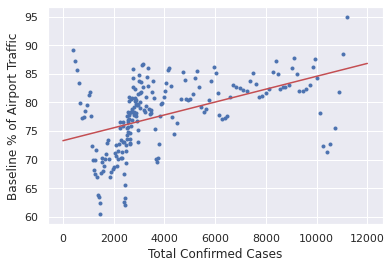

In [7]:
# What about confirmed?
#smooth it, and then plot it
confirm_smooth = lowess(joined['Confirmed'], joined["Date"], frac =0.04) #to reduce weekly cycle effect 7/214 = 0.327
confirmX = confirm_smooth[:,1]
plt.plot(confirmX,y, 'b.')
plt.xlabel('Total Confirmed Cases')
plt.ylabel('Baseline % of Airport Traffic')
reg = stats.linregress(confirmX, y)
print(reg.rvalue)
linearX = np.linspace(0,12000)
plt.plot(linearX, reg.slope*linearX + reg.intercept,'r-')
# slightly better but still terrible. Though interesting to see that consistent dip in airport traffic when the 
# total was around 2000 this was probably due to the inital shock in the early parts of the pandemic
plt.savefig('graphs/png/YVR/YVRCorr2.png', bbox_inches='tight', dpi = 150)

0.5599353142330102
0.6947598256680936


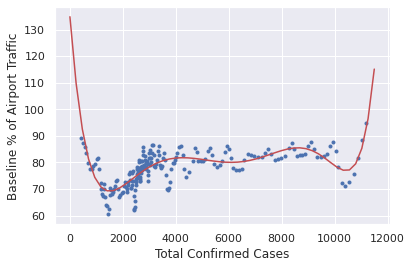

In [8]:
# It doesn't seem like linear regression is what we want, let's try a polynomial
# The data shows 2 dips --> matches with knowledge of the two waves
plt.plot(confirmX,y, 'b.')
plt.xlabel('Total Confirmed Cases')
plt.ylabel('Baseline % of Airport Traffic')

X = np.stack([confirmX], axis =1)
X_train,X_valid,y_train,y_valid = train_test_split(X,y)

poly_regress = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=8, include_bias = True),
    LinearRegression(fit_intercept = False))
poly_regress.fit(X_train, y_train)

linearX = np.stack([np.linspace(0,11500)],axis=1)

plt.plot(linearX, poly_regress.predict(linearX), 'r-')
print(poly_regress.score(X_train,y_train))
print(poly_regress.score(X_valid,y_valid))
# Oh hey we get something pretty good, but with poly regression, we can't exactly 
# predict into the future
plt.savefig('graphs/png/YVR/YVRCorr3.png', bbox_inches='tight', dpi = 150)

-0.4693023697196381
-0.9176082647508533


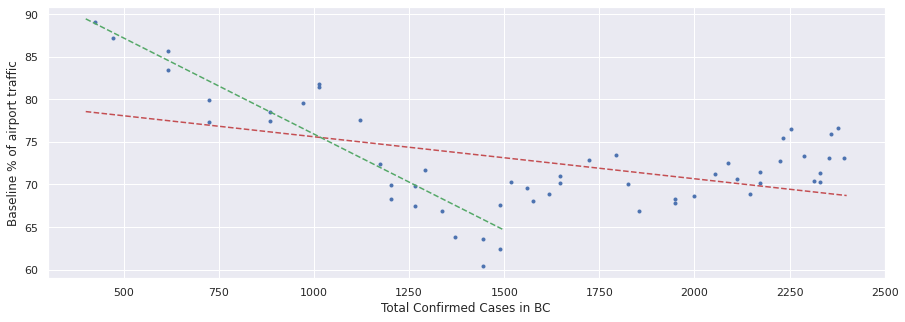

In [9]:
# Analyzing statistical correlation in --> full first wave
first_wave = joined[joined['Date']<'2020-05-15']
plt.figure(figsize = (15,5))

"""plt.plot(first_wave["Date"], first_wave['PercentOfBaseline'], 'b.', label = 'Percentage Baseline', alpha=0.7)
plt.plot(first_wave["Date"], first_wave['Baseline_smooth'],'b-',label = 'Smoothed % Baseline')
plt.plot(first_wave["Date"], first_wave["Diff_smooth"], 'r-', label = 'Smoothed New Cases', alpha = 0.5)
plt.plot(first_wave["Date"], first_wave['Difference'], 'r.', label = 'New Cases', alpha = 0.7)
plt.xlabel("Mid-March to Mid-May: First Wave")
plt.legend()
plt.show() #two things over time"""

plt.plot(first_wave["Confirmed"],first_wave["Baseline_smooth"], 'b.')
plt.xlabel("Total Confirmed Cases in BC")
plt.ylabel("Baseline % of airport traffic")

regression = stats.linregress(first_wave["Confirmed"], first_wave["Baseline_smooth"])
print(regression.rvalue)

linearX = np.linspace(400,2400)
plt.plot(linearX, regression.slope*linearX + regression.intercept,'r--')

# We can clearly see that while there was a huge decrease in airport traffic in the 
# beginning, but it recovered over time back to the new normal
# how about when we try to only look at the first 25 days? 
reg2 = stats.linregress(first_wave["Confirmed"].head(25), first_wave["Baseline_smooth"].head(25))
print(reg2.rvalue)
lin2 = np.linspace(400,1500)
plt.plot(lin2, reg2.slope*lin2+ reg2.intercept,'g--')
# get rvalue showing there is indeed a close linear correlation in the first 'shock'
# but later on, no longer the same correlation
plt.savefig('graphs/png/YVR/YVRWave.png', bbox_inches='tight', dpi = 150)

0.725084952017734
0.609484400952061


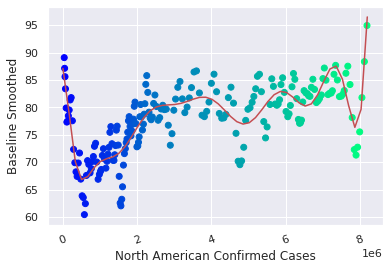

In [10]:
# This is to make sure both yvr and naCases start and end on the same dates
if (yvr.count().loc['Date'] != naCases.count().loc['Date']):
    na = naCases[["Date","Confirmed","New"]].join(yvr[["Date","PercentOfBaseline","Baseline_smooth"]].set_index('Date'), on='Date')
    na = na.dropna()

plt.scatter(na['Confirmed'],na['Baseline_smooth'],c=na['Date'],cmap='winter' )
plt.xlabel("North American Confirmed Cases")
plt.xticks(rotation=20)
plt.ylabel("Baseline Smoothed")

X = np.stack([na['Confirmed']], axis =1)
X_train,X_valid,y_train,y_valid = train_test_split(X,np.stack([na['Baseline_smooth']], axis =1))

poly_regress = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=14, include_bias = True),
    LinearRegression(fit_intercept = False))
poly_regress.fit(X_train, y_train)

linearX = np.stack([np.linspace(0,8200000)],axis=1)

plt.plot(linearX, poly_regress.predict(linearX), 'r-')
print(poly_regress.score(X_train,y_train))
print(poly_regress.score(X_valid,y_valid))
plt.savefig('graphs/png/YVR/YVRML.png', bbox_inches='tight', dpi = 150)

In [11]:
# ML with new cases, total cases, na cases: total + new, vs y= Baseline
#naCases --> Confirmed, New, New_smooth, Confirm_smooth
#joined --> Confirmed, Confirmed_smooth, Difference, Diff_smooth, Baseline_smooth, PercentOfBaseline

joined["Confirmed_smooth"] = confirmX
joined
# X --> na_confirm, na_new, bc_confirm, bc_new
X = naCases[["Confirm_smooth", "New_smooth", "Date"]].join(joined[["Confirmed_smooth","Diff_smooth","Date"]].set_index('Date'), on ='Date')
X = X.rename(columns={"Confirm_smooth": "na_confirm", "New_smooth":"na_new", "Confirmed_smooth":"bc_confirm", "Diff_smooth":"bc_new"})
X = X[["na_confirm","na_new","bc_confirm","bc_new"]].dropna()

# y --> joined['Baseline_smooth']
y = joined['Baseline_smooth'].rename(columns={"Baseline_smooth":"yvrBaseline"})

TypeError: rename() got an unexpected keyword argument 'columns'

In [12]:
# GB regressor does the best out of all of them bc diff factors are weighed differently
# Also not that much data, so neural network doesn't really work
gbmodel = make_pipeline(
    MinMaxScaler(),
    GradientBoostingRegressor(n_estimators=50, max_depth=5)
    )
gbmodel.fit(X_train, y_train)

print(gbmodel.score(X_train,y_train), gbmodel.score(X_valid,y_valid))

0.9751135963136023 0.7998359771263922


/home/dogfish/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
